# Стискання зображень

У цій задачі ми використаємо K-Means кластеризацію для стискання зображення шляхом зменшення кількості кольорів.

Вхідне зображення складається з $512 \times 512$ пікселів, кожен із яких заданий $24$-бітним кольором (по $8$ бітів на кожну з RGB-компонент). Якщо це зображення зберігати попіксельно, воно займатиме $512 \times 512 \times 3 = 786432$ байти.

Якщо ми зможемо зменшити кількість кольорів із $(2^8)^3$ до $16$, це дозволить використати лише $\log_2 16 = 4$ біти для кодування кольору замість $24$, в результаті стискаючи зображення у $6$ разів.

Проблема полягає лише в тому, як обрати кольори так, щоб втратити мінімум інформації. Для цього ми й застосуємо кластеризацію. Ми знайдемо 16 груп подібних кольорів, і замінимо кожен 24-бітний колір на центроїд відповідної для нього групи.

In [1]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm_notebook as progressbar

In [3]:
%matplotlib inline

## Налаштування

Зображення, яке потрібно стиснути.

In [4]:
input_image_file = "mandrill-large.png"

Кількість кольорів, які дозволено використовувати у вихідному зображенні. Вона ж — кількість кластерів.

In [5]:
num_colors = num_clusters = 16

Параметри K-means: кількість ітерацій та стан генератора випадкових чисел.

In [6]:
num_iterations = 150
random_seed = 42

Поріг збіжності kmeans_objective функції (для ранньої зупинки алгоритму).

In [7]:
convergence_eps = 0.01

## Підготовка даних

Завантажуємо зображення як масив пікселів:

In [8]:
input_img = img.imread(input_image_file)

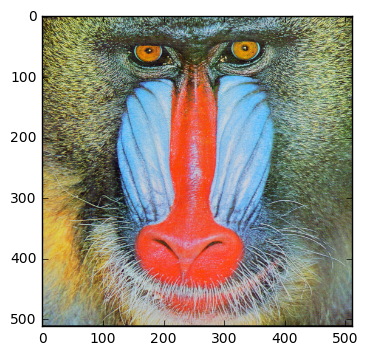

In [9]:
plt.imshow(input_img)
plt.show()

Формуємо стандартну навчальну матрицю $m \times n$:

In [10]:
color_depth = input_img.shape[-1]

In [11]:
X = input_img.reshape(-1, color_depth)

In [12]:
X.shape

(262144, 3)

## Кластеризація K-Means

In [13]:
np.random.seed(random_seed)

Ініціалізуємо центроїди кластерів, обираючи в якості кожного центроїда колір випадкового пікселя.

In [14]:
centroids = X[np.random.choice(len(X), size=num_clusters, replace=False)]

Візуалізуємо центроїди

In [15]:
def visualize_cetroids(centroids):
    x = []
    y = []
    z = []
    for center in centroids:
        x.append(center[0])
        y.append(center[1])
        z.append(center[2])

    ax = plt.subplot()
    ax.tricontourf(x,y,z, num_clusters)
    ax.plot(x,y, 'ko ')

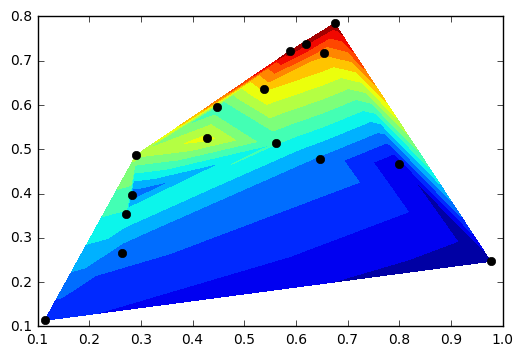

In [16]:
visualize_cetroids(centroids)

In [17]:
closest_centroids = np.zeros(len(X))

Знайдіть номер найближчого центроїда для кожної точки.

In [18]:
def get_closest_centroids(X, centroids):
    closest_centroids_indexes = []
    for x in X:
        idx = (np.linalg.norm(np.abs(centroids - x), axis=1)**2).argmin()
        closest_centroids_indexes.append(idx)
            
    return closest_centroids_indexes

Змістіть координати центроїдів, знаючи, до якого центроїда найближча кожна точка.

In [19]:
def move_centroids(X, closest_centroids, num_clusters):
    moved_centroids = []
    for cluster in np.arange(num_clusters):
        cluster_dots = [X[i] for i,x in enumerate(closest_centroids) if x == cluster]
        moved_centroids.append(np.mean(np.asarray(cluster_dots), axis = 0))
    return np.asarray(moved_centroids)

Обчисліть цільову функцію K-Means:

$ J = \sum\limits_{j=1}^k {\sum\limits_{i=1}^{m} \Vert x_i^{(j)} - c_j \Vert^2} $

In [20]:
def kmeans_objective(X, centroids, closest_centroids):
    distance = 0;
    for index, centerIndex in enumerate(closest_centroids):
        distance = distance + np.linalg.norm(X[index] - centroids[centerIndex])**2
    
    return distance

Виконуємо ітерації K-Means.

In [21]:
objective_history = []

In [22]:
for iteration in progressbar(range(num_iterations), desc="Iterations"):
    # Cluster assignment.
    closest_centroids = get_closest_centroids(X, centroids)

    # Move centroids.
    centroids = move_centroids(X, closest_centroids, num_clusters)
    
    # Compute the objective.
    objective = kmeans_objective(X, centroids, closest_centroids)
    objective_history.append(objective)
    
    print("Iteration: {0:2d}    Objective: {1:.3f}".format(iteration + 1, objective))
    
    if len(objective_history) > 2 and np.abs(objective_history[-1] - objective_history[-2]) < convergence_eps:
        print("K-Means has converged. Stopping early.")
        break

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Iteration:  1    Objective: 3944.992
Iteration:  2    Objective: 3177.258
Iteration:  3    Objective: 2801.627
Iteration:  4    Objective: 2694.781
Iteration:  5    Objective: 2651.834
Iteration:  6    Objective: 2627.178
Iteration:  7    Objective: 2612.410
Iteration:  8    Objective: 2603.148
Iteration:  9    Objective: 2596.754
Iteration: 10    Objective: 2592.063
Iteration: 11    Objective: 2588.445
Iteration: 12    Objective: 2585.334
Iteration: 13    Objective: 2582.445
Iteration: 14    Objective: 2579.725
Iteration: 15    Objective: 2577.236
Iteration: 16    Objective: 2574.968
Iteration: 17    Objective: 2572.852
Iteration: 18    Objective: 2570.783
Iteration: 19    Objective: 2568.673
Iteration: 20    Objective: 2566.594
Iteration: 21    Objective: 2564.570
Iteration: 22    Objective: 2562.630
Iteration: 23    Objective: 2560.723
Iteration: 24    Objective: 2558.782
Iteration: 25    Objective: 2556.823
Iteration: 26    Objective: 2555.025
Iteration: 27    Objective: 2553.350
I

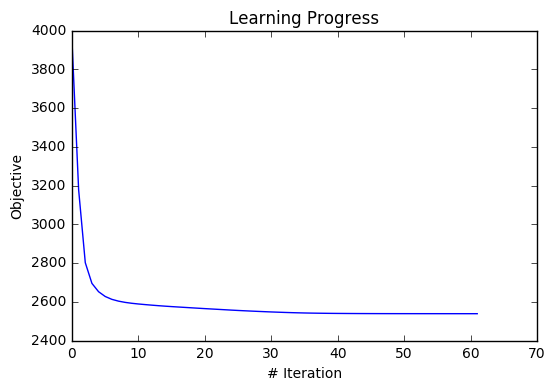

In [23]:
ax = plt.plot(objective_history)[0].axes

ax.set(xlabel="# Iteration")
ax.set(ylabel="Objective")
ax.set(title="Learning Progress")

plt.show()

## Результат стискання

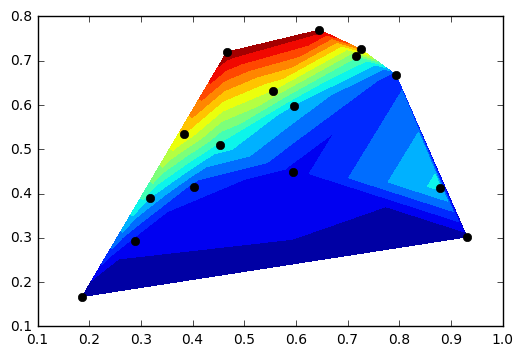

In [24]:
visualize_cetroids(centroids)

Кодуємо кожен колір як найближчий до нього центроїд.

In [25]:
output_img = centroids[closest_centroids].reshape(input_img.shape)

Порівнюємо зображення «до» і «після».

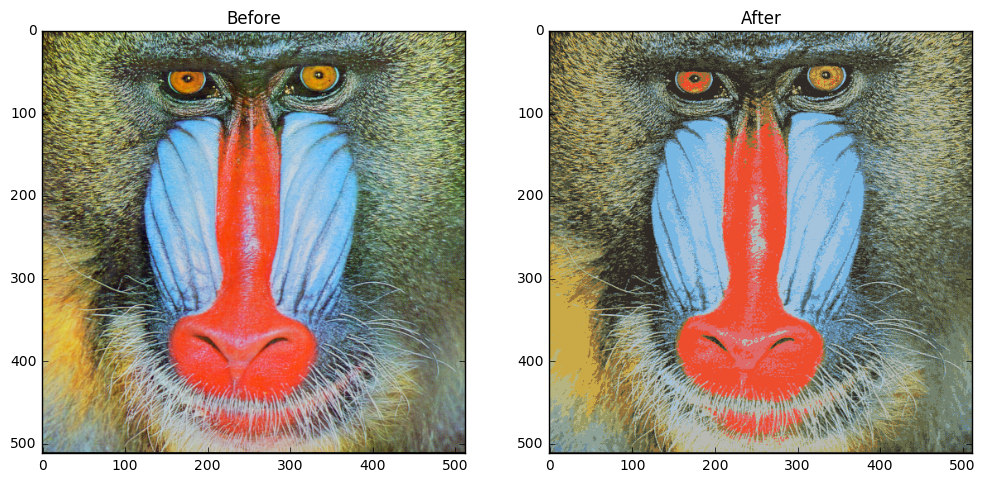

In [26]:
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(12, 12))

ax_before.imshow(input_img)
ax_after.imshow(output_img)

ax_before.set(title="Before")
ax_after.set(title="After")

plt.show()